In [101]:
#Check GPU
!nvidia-smi -L

GPU 0: Tesla K80 (UUID: GPU-619882fa-7415-1699-550e-3aaa9340454f)


### Add data

In [102]:
import zipfile
# Download data (same as from Kaggle)
!wget "https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip"

# Unzip data

zip_ref = zipfile.ZipFile("nlp_getting_started.zip", "r")
zip_ref.extractall()
zip_ref.close()

--2021-10-26 10:42:57--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.120.128, 142.250.128.128, 142.251.6.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.120.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip.1’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.006s  

2021-10-26 10:42:57 (89.6 MB/s) - ‘nlp_getting_started.zip.1’ saved [607343/607343]



## EDA

In [103]:
import pandas as pd

pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

In [104]:
print(train_data.shape ,test_data.shape)
train_data.sample(frac=1,random_state=42).head()

(7613, 5) (3263, 4)


,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [105]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


 WE have 2 features that have NAN-values 





### Count plot

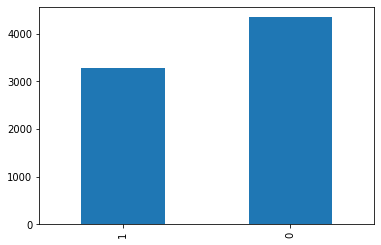

In [106]:
# Check our target is balenced or not!
train_data.target.value_counts().sort_values().plot(kind = 'bar')

### Visit some random data

In [107]:
import random
randomIndex = random.randint(0, len(train_data)-5) 
for row in train_data[["text", "target"]][randomIndex:randomIndex+5].itertuples():
  _, text, target = row
  print(f"Target: {target}", "(real disaster)" if target > 0 else "(not real disaster)")
  print(f"Text:\n{text}\n")
  print("---\n")

Target: 0 (not real disaster)
Text:
6.Beyonce Is my pick for http://t.co/thoYhrHkfJ Fan Army #Beyhive http://t.co/WvJ39a3BGM

---

Target: 0 (not real disaster)
Text:
POTUS appoints Brig. Gen. Richard G. Kaiser as member of the Mississippi River Commission. Learn more about the MRC: http://t.co/vdUKcV7YJy

---

Target: 1 (real disaster)
Text:
@AP what a violent country get the army involved to help control the killings and bring back peace to the poor people.

---

Target: 0 (not real disaster)
Text:
WWI WWII JAPANESE ARMY NAVY MILITARY JAPAN LEATHER WATCH WAR MIDO WW1 2 - Full read by eBay http://t.co/QUmcE7W2tY http://t.co/KTKG2sDhHl

---

Target: 0 (not real disaster)
Text:
WWI WWII JAPANESE ARMY NAVY MILITARY JAPAN LEATHER WATCH WAR MIDO WW1 2 - Full read by eBay http://t.co/obfD7e4QcP http://t.co/yAZjE5OwVk

---



## Data prepration

### split data

In [108]:
from sklearn.model_selection import train_test_split

xTrain, xVal, yTrain, yVal = train_test_split(train_data["text"].to_numpy(),
                                                                            train_data["target"].to_numpy(),
                                                                            test_size=0.15,
                                                                            random_state=55)
xTest = pd.read_csv('test.csv')
id = xTest['id']

### Text Vectorization

In [109]:
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

textVector = TextVectorization(max_tokens=None,
                                    standardize="lower_and_strip_punctuation", 
                                    split="whitespace",
                                    ngrams=None, 
                                    output_mode="int",
                                    output_sequence_length=None) 


In [110]:
# Find average number of tokens (words) in training Tweets
avrageWord = round(sum([len(i.split()) for i in xTrain])/len(xTrain))

In [111]:
textVector.adapt(xTrain)

In [112]:
textVector(['This is my first sentence'])

<tf.Tensor: shape=(1, 5), dtype=int64, numpy=array([[19,  9, 13, 96,  1]])>

In [113]:
textVector.get_vocabulary()

['',
 '[UNK]',
 'the',
 'a',
 'in',
 'to',
 'of',
 'and',
 'i',
 'is',
 'for',
 'on',
 'you',
 'my',
 'it',
 'that',
 'with',
 'at',
 'by',
 'this',
 'from',
 'be',
 'are',
 'have',
 'was',
 'like',
 'as',
 'up',
 'just',
 'so',
 'me',
 'but',
 'your',
 'im',
 'amp',
 'not',
 'its',
 'out',
 'all',
 'no',
 'will',
 'has',
 'after',
 'an',
 'when',
 'if',
 'fire',
 'we',
 'get',
 'via',
 'new',
 'now',
 'more',
 'about',
 'what',
 'they',
 'one',
 'or',
 'dont',
 'he',
 'been',
 'news',
 'over',
 'people',
 'how',
 'who',
 'into',
 'were',
 'can',
 'do',
 'video',
 'us',
 '2',
 'emergency',
 'disaster',
 'there',
 'than',
 'police',
 'would',
 'her',
 'his',
 'still',
 'why',
 'back',
 'crash',
 'body',
 'storm',
 'suicide',
 'some',
 'california',
 'know',
 'time',
 'got',
 'them',
 'rt',
 'man',
 'first',
 'see',
 'had',
 'day',
 'burning',
 'off',
 'cant',
 'bomb',
 'attack',
 'nuclear',
 'going',
 'fires',
 'youtube',
 'full',
 'world',
 'our',
 'buildings',
 '3',
 'love',
 'their',

## Modeling and Training

### Model 0

In [114]:
import tensorflow as tf

embedding = tf.keras.layers.Embedding(input_dim=1000,
                             output_dim=128,
                             embeddings_initializer="uniform",
                             input_length=avrageWord,
                             name="embedding_1")

embedding

In [115]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create tokenization and modelling pipeline
model0 = Pipeline([
                    ("tfidf", TfidfVectorizer()), # convert words to numbers using tfidf
                    ("clf", MultinomialNB()) # model the text
])

# Fit the pipeline to the training data
model0.fit(xTrain, yTrain)



Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [116]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Create a function for cal. score of our model ( will be used on other models)
def CalculateResults(yTrue, yPred):

  # Calculate model accuracy
  modelAccuracy = accuracy_score(yTrue, yPred) * 100
  # Calculate model precision, recall and f1 score using "weighted" average
  modelPrecision, modelRecall, modelF1, _ = precision_recall_fscore_support(yTrue, yPred, average="weighted")
  modelResults = {"accuracy": modelAccuracy,
                  "precision": modelPrecision,
                  "recall": modelRecall,
                  "f1": modelF1}
  return modelResults

### Score model 0

In [117]:
yPred = model0.predict(xVal)
resualt0 = CalculateResults(yVal,yPred)

### Predict for kaggle score: 79.4

In [118]:
resualt = model0.predict(xTest['text'])
resualt = tf.squeeze(tf.round(resualt))
resaultDataframe = pd.DataFrame({'id':id,'target':resualt})
resaultDataframe.to_csv('submission.csv',index=False)

### Model 1

In [119]:
import datetime
def CreateTensorboardCallback(dirName, experimentName):

  logDir = dirName + "/" + experimentName + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboardCallback = tf.keras.callbacks.TensorBoard(
      log_dir=logDir
  )
  print(f"Saving TensorBoard log files to: {logDir}")
  return tensorboardCallback

In [120]:
SAVE_DIR = "model_logs"

In [121]:
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string") # inputs are 1-dimensional strings
x = textVector(inputs) # turn the input text into numbers
x = embedding(x) 
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model1 = tf.keras.Model(inputs, outputs, name="model_1_dense") 

In [122]:
# Compile model
model1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [123]:
# Fit the model
model1History = model1.fit(xTrain, # input sentences can be a list of strings due to text preprocessing layer built-in model
                              yTrain,
                              epochs=5,
                              validation_data=(xVal, yVal),
                              callbacks=[CreateTensorboardCallback(dirName=SAVE_DIR, 
                                                                     experimentName="simple_dense_model")])

Saving TensorBoard log files to: model_logs/simple_dense_model/20211026-104259
Epoch 1/5
203/203 [==============================] - 3s 11ms/step - loss: 0.6467 - accuracy: 0.6151 - val_loss: 0.5857 - val_accuracy: 0.7548
Epoch 2/5
203/203 [==============================] - 2s 9ms/step - loss: 0.5329 - accuracy: 0.7719 - val_loss: 0.4953 - val_accuracy: 0.7723
Epoch 3/5
203/203 [==============================] - 2s 8ms/step - loss: 0.4646 - accuracy: 0.8051 - val_loss: 0.4667 - val_accuracy: 0.7837
Epoch 4/5
203/203 [==============================] - 2s 8ms/step - loss: 0.4302 - accuracy: 0.8159 - val_loss: 0.4573 - val_accuracy: 0.7855
Epoch 5/5
203/203 [==============================] - 2s 8ms/step - loss: 0.4077 - accuracy: 0.8285 - val_loss: 0.4575 - val_accuracy: 0.7872


In [124]:
yPred = model1.predict(xVal)
yPred = tf.squeeze(tf.round(yPred))
resualt1 = CalculateResults(yVal,yPred)


### Visualizing embedding words

In [125]:
wordsInVocab = textVector.get_vocabulary()
embedWeights = model1.get_layer("embedding_1").get_weights()[0]
embedWeights.shape , len(wordsInVocab), wordsInVocab[:10]

((1000, 128),
 20255,
 ['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is'])

In [126]:
import io
# Create output writers
out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(wordsInVocab[:1000]):
  if index == 0:
    continue  # skip 0, it's padding.
  vec = embedWeights[index]
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  out_m.write(word + "\n")
out_v.close()
out_m.close()

http://projector.tensorflow.org/ visualizing data

### Model 2


In [127]:
tf.random.set_seed(42)
from tensorflow.keras import layers
model2Embedding = layers.Embedding(input_dim=1000,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=avrageWord,
                                     name="embedding_2")


# Create LSTM model
inputs = layers.Input(shape=(1,), dtype="string")
x = textVector(inputs)
x = model2Embedding(x)
print(x.shape)
# x = layers.LSTM(64, return_sequences=True)(x) # return vector for each word in the Tweet (you can stack RNN cells as long as return_sequences=True)
x = layers.LSTM(64)(x) # return vector for whole sequence
print(x.shape)
# x = layers.Dense(64, activation="relu")(x) # optional dense layer on top of output of LSTM cell
outputs = layers.Dense(1, activation="sigmoid")(x)
model2 = tf.keras.Model(inputs, outputs, name="model_2_LSTM")

(None, None, 128)
(None, 64)


In [128]:

# Compile model
model2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [129]:
model2History = model2.fit(xTrain,
                              yTrain,
                              epochs=5,
                              validation_data=(xVal, yVal),
                              callbacks=[CreateTensorboardCallback(SAVE_DIR, 
                                                                     "LSTM")])

Saving TensorBoard log files to: model_logs/LSTM/20211026-104310
Epoch 1/5
203/203 [==============================] - 6s 19ms/step - loss: 0.5602 - accuracy: 0.7061 - val_loss: 0.4632 - val_accuracy: 0.7925
Epoch 2/5
203/203 [==============================] - 3s 14ms/step - loss: 0.4246 - accuracy: 0.8193 - val_loss: 0.4651 - val_accuracy: 0.7820
Epoch 3/5
203/203 [==============================] - 3s 13ms/step - loss: 0.4009 - accuracy: 0.8346 - val_loss: 0.4967 - val_accuracy: 0.7723
Epoch 4/5
203/203 [==============================] - 3s 14ms/step - loss: 0.3839 - accuracy: 0.8425 - val_loss: 0.4793 - val_accuracy: 0.7837
Epoch 5/5
203/203 [==============================] - 3s 14ms/step - loss: 0.3673 - accuracy: 0.8492 - val_loss: 0.4841 - val_accuracy: 0.7688


In [130]:
yPred2 = model2.predict(xVal)
yPred2 = tf.squeeze(tf.round(yPred2))
resualt2 = CalculateResults(yVal,yPred2)


In [131]:
tf.random.set_seed(42)
from tensorflow.keras import layers
model3Embedding = layers.Embedding(input_dim=1000,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=avrageWord,
                                     name="embedding_3")


# Create GRu model
inputs = layers.Input(shape=(1,), dtype="string")
x = textVector(inputs)
x = model3Embedding(x)
print(x.shape)

x = layers.GRU(64)(x) 
print(x.shape)

outputs = layers.Dense(1, activation="sigmoid")(x)
model3 = tf.keras.Model(inputs, outputs, name="model_3_GRU")

(None, None, 128)
(None, 64)


### Model 4 

In [132]:
# Compile GRU model
model3.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [133]:
model3History = model3.fit(xTrain,
                              yTrain,
                              epochs=5,
                              validation_data=(xVal, yVal),
                              callbacks=[CreateTensorboardCallback(SAVE_DIR, 
                                                                     "GRU")])

Saving TensorBoard log files to: model_logs/GRU/20211026-104334
Epoch 1/5
203/203 [==============================] - 6s 19ms/step - loss: 0.6608 - accuracy: 0.5999 - val_loss: 0.5142 - val_accuracy: 0.7706
Epoch 2/5
203/203 [==============================] - 3s 14ms/step - loss: 0.4599 - accuracy: 0.7979 - val_loss: 0.4609 - val_accuracy: 0.7925
Epoch 3/5
203/203 [==============================] - 3s 14ms/step - loss: 0.4078 - accuracy: 0.8292 - val_loss: 0.4937 - val_accuracy: 0.7811
Epoch 4/5
203/203 [==============================] - 3s 13ms/step - loss: 0.3885 - accuracy: 0.8397 - val_loss: 0.4795 - val_accuracy: 0.7837
Epoch 5/5
203/203 [==============================] - 3s 14ms/step - loss: 0.3730 - accuracy: 0.8516 - val_loss: 0.4839 - val_accuracy: 0.7785


In [134]:
yPred3 = model3.predict(xVal)
yPred3 = tf.squeeze(tf.round(yPred3))
resualt3 = CalculateResults(yVal,yPred3)


### Model 4


In [135]:
tf.random.set_seed(42)
from tensorflow.keras import layers
model4Embedding = layers.Embedding(input_dim=1000,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=avrageWord,
                                     name="embedding_4")


# Create RNN model
inputs = layers.Input(shape=(1,), dtype="string")
x = textVector(inputs)
x = model4Embedding(x)
print(x.shape)

x = layers.Bidirectional(layers.LSTM(64))(x) # bidirectional goes both ways so has double the parameters of a regular LSTM layer
outputs = layers.Dense(1, activation="sigmoid")(x)


model4 = tf.keras.Model(inputs, outputs, name="model_4_RNN")

(None, None, 128)


In [136]:

# Compile
model4.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [137]:
model4History = model4.fit(xTrain,
                              yTrain,
                              epochs=5,
                              validation_data=(xVal, yVal),
                              callbacks=[CreateTensorboardCallback(SAVE_DIR, 
                                                                     "RNN")])

Saving TensorBoard log files to: model_logs/RNN/20211026-104359
Epoch 1/5
203/203 [==============================] - 10s 29ms/step - loss: 0.5326 - accuracy: 0.7251 - val_loss: 0.4498 - val_accuracy: 0.7942
Epoch 2/5
203/203 [==============================] - 4s 21ms/step - loss: 0.4139 - accuracy: 0.8200 - val_loss: 0.4571 - val_accuracy: 0.7828
Epoch 3/5
203/203 [==============================] - 4s 21ms/step - loss: 0.3899 - accuracy: 0.8336 - val_loss: 0.4744 - val_accuracy: 0.7758
Epoch 4/5
203/203 [==============================] - 4s 21ms/step - loss: 0.3743 - accuracy: 0.8404 - val_loss: 0.4697 - val_accuracy: 0.7802
Epoch 5/5
203/203 [==============================] - 4s 21ms/step - loss: 0.3511 - accuracy: 0.8447 - val_loss: 0.4771 - val_accuracy: 0.7688


In [138]:
yPred4 = model4.predict(xVal)
yPred4 = tf.squeeze(tf.round(yPred4))
resualt4 = CalculateResults(yVal,yPred4)


### Model 5


In [139]:
# Example of pretrained embedding with universal sentence encoder - https://tfhub.dev/google/universal-sentence-encoder/4
import tensorflow_hub as hub
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4") # load Universal Sentence Encoder


In [140]:
# We can use this encoding layer in place of our text_vectorizer and embedding layer
sentenceEncoderLayer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[], # shape of inputs coming to our model 
                                        dtype=tf.string, # data type of inputs coming to the USE layer
                                        trainable=False, # keep the pretrained weights (we'll create a feature extractor)
                                        name="USE")

In [141]:
# Create model using the Sequential API
model5 = tf.keras.Sequential([
  sentenceEncoderLayer, # take in sentences and then encode them into an embedding
  layers.Dense(64, activation="relu"),
  layers.Dense(1, activation="sigmoid")
], name="model_5_USE")

# Compile model
model5.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [142]:
model5History = model4.fit(xTrain,
                              yTrain,
                              epochs=5,
                              validation_data=(xVal, yVal),
                              callbacks=[CreateTensorboardCallback(SAVE_DIR, 
                                                                     "RNN")])

Saving TensorBoard log files to: model_logs/RNN/20211026-104455
Epoch 1/5
203/203 [==============================] - 6s 31ms/step - loss: 0.3277 - accuracy: 0.8642 - val_loss: 0.5336 - val_accuracy: 0.7609
Epoch 2/5
203/203 [==============================] - 4s 21ms/step - loss: 0.3070 - accuracy: 0.8717 - val_loss: 0.5238 - val_accuracy: 0.7688
Epoch 3/5
203/203 [==============================] - 4s 21ms/step - loss: 0.2820 - accuracy: 0.8841 - val_loss: 0.6026 - val_accuracy: 0.7539
Epoch 4/5
203/203 [==============================] - 4s 21ms/step - loss: 0.2688 - accuracy: 0.8838 - val_loss: 0.6040 - val_accuracy: 0.7426
Epoch 5/5
203/203 [==============================] - 4s 21ms/step - loss: 0.2426 - accuracy: 0.8983 - val_loss: 0.6063 - val_accuracy: 0.7434


In [143]:
yPred5 = model5.predict(xVal)
yPred5 = tf.squeeze(tf.round(yPred5))
resualt5 = CalculateResults(yVal,yPred5)


In [144]:

# Combine model results into a DataFrame
allModelRresults = pd.DataFrame({"naive": resualt0,
                                  "ANN": resualt1,
                                  "lstm": resualt2,
                                  "gru": resualt3,
                                  "RNN": resualt4,
                                  "transfer learning": resualt5,
})
allModelRresults = allModelRresults.transpose()
allModelRresults

,accuracy,precision,recall,f1
naive,79.159370,0.801303,0.791594,0.785103
ANN,78.721541,0.786869,0.787215,0.785288
lstm,76.882662,0.768848,0.768827,0.765824
gru,77.845884,0.781198,0.778459,0.774090
RNN,76.882662,0.768026,0.768827,0.766782
transfer learning,47.635727,0.563600,0.476357,0.411437
